In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR,ReduceLROnPlateau,ExponentialLR
#torch.multiprocessing.set_start_method("spawn")
import resnet_angle
from skimage import transform as tf
from sklearn.model_selection import KFold
import os 
import numpy as np
import pandas as pd
from utils import progress_bar

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
# test = pd.read_json(BASE_dir + 'test.json')

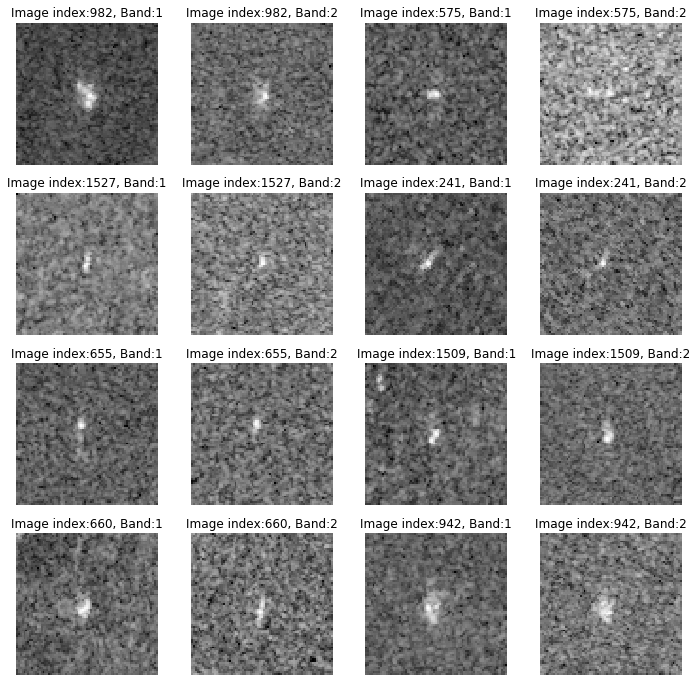

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [18]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=1).copy()
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=2).copy()
            rotate = np.random.randint(4, size=1)
            if rotate:
                img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

    
class iceberg_angle_dataset(Dataset):
    def __init__(self, data,angle, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.angle=torch.from_numpy(angle).type(torch.FloatTensor)
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label, angle=  self.data[idx], self.label[idx], self.angle[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                rotate = np.random.randint(4, size=1)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
                pass
        img = torch.from_numpy(img).type(dtype)
#         img = self.transform(img)

        return img, angle,label
    
    
    
def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [4]:
train_X_del = train_X#[data.inc_angle!='na',:,:,:]
train_y_del = train_y#[data.inc_angle!='na']
result = []
for num,i in enumerate(train_X_del):
    temp = []
    for j in i:
        temp.append(tf.rescale(j,224/75,mode='constant'))
    img = np.stack(temp)
    result.append(img)
    if num%50==0:
        print('We are %d'%num)
train_X_del = np.stack(result)

We are 0
We are 50
We are 100
We are 150
We are 200
We are 250
We are 300
We are 350
We are 400
We are 450
We are 500
We are 550
We are 600
We are 650
We are 700
We are 750
We are 800
We are 850
We are 900
We are 950
We are 1000
We are 1050
We are 1100
We are 1150
We are 1200
We are 1250
We are 1300
We are 1350
We are 1400
We are 1450
We are 1500
We are 1550
We are 1600


In [18]:
train_index=list(range(1300))
val_index= list(range(1300,1604))
# train_index=list(range(304,1604)) 
# val_index= list(range(304))
train_X[train_index].shape

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size = 16, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [14]:
#data.inc_angle[data.inc_angle=='na']=0
data.inc_angle

0       43.9239
1       38.1562
2       45.2859
3       43.8306
4       35.6256
5       36.9034
6       34.4751
7       41.1769
8       35.7829
9       43.3007
10       44.624
11      39.5067
12      41.8544
13      45.2909
14      34.7715
15       43.782
16      45.3568
17      38.7812
18      42.5145
19      37.2802
20      41.7973
21      38.0669
22      39.6636
23      37.6866
24       40.296
25       39.234
26      40.3904
27      43.7895
28      42.5891
29      41.0303
         ...   
1574          0
1575          0
1576          0
1577          0
1578          0
1579          0
1580          0
1581          0
1582          0
1583          0
1584          0
1585          0
1586          0
1587          0
1588          0
1589          0
1590          0
1591          0
1592          0
1593          0
1594          0
1595          0
1596          0
1597          0
1598          0
1599          0
1600          0
1601          0
1602          0
1603          0
Name: inc_angle, Length:

In [19]:
train_X_del = train_X
data.loc[data.inc_angle=='na', 'inc_angle']=0
train_angle_del = data['inc_angle'].values
train_angle_del = train_angle_del.astype(np.float)
train_angle=train_angle_del
train_y_del = train_y#[data.inc_angle!='na']
# train_X_del = train_X
# train_y_del = train_y

seed= np.random.RandomState(123)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
train_index, val_index = next(spliter.split(train_X_del))
# # train_index=list(range(284,1471)) 
# # val_index= list(range(284))

train_mean, train_std = transform_compute(train_X_del[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])
#af_train_X,af_train_angle, af_train_y = data_aug(train_X_del[train_index], train_angle_del[train_index],train_y_del[train_index])
#af_train_X, af_train_y = data_aug2(train_X_del[train_index], train_y_del[train_index])
af_train_X, af_train_angle ,af_train_y = train_X_del[train_index],train_angle_del[train_index], train_y_del[train_index]

train_dataset = iceberg_angle_dataset(data= af_train_X,angle=af_train_angle, label=af_train_y, transform=train_transform,
                                     test=False)
val_dataset = iceberg_angle_dataset(data= train_X_del[val_index], angle= train_angle_del[val_index],
                                    label=train_y_del[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 16, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


In [20]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [5]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step()
#         scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x,batch_angle, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_angle = batch_angle.unsqueeze(1)
            batch_angle=batch_angle.type(torch.FloatTensor)
            if use_cuda:
                batch_x,batch_angle, batch_y = batch_x.cuda(),batch_angle.cuda(),batch_y.cuda()
            x = Variable(batch_x)
            angle = Variable(batch_angle)
            y = Variable(batch_y)
            out = net((x, angle))
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'resnet34_ang_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'resnet34_ang_loss.pth')
            if loss_avg/total >val_loss:
                e_s=0

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss,best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x,val_angle, val_y) in enumerate(val_load):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [ ]:
result={}

drop1_list = [0.3,0.4,0.5,0.6,0.7]
drop2_list = [0.4,0.5,0.8,0.6,0.7]
for i in range(20):
    drop1 = drop1_list[np.random.randint(5,size=1)[0]]
    drop2 = drop2_list[np.random.randint(5,size=1)[0]]
    wd = np.exp(np.random.uniform(np.log(0.0001),np.log(0.05),size=1)[0])
    
    msg = 'Round {}, drop1: {}, drop2:{}, wd: {}'.format(i,drop1,drop2,wd)
    print(msg)
    resnet50_net = resnet_angle.resnet50(pretrained=True)
    net= resnet50_net
    net.fc = nn.Sequential(
        nn.Linear(512 * 4+1,256 * 4),
        nn.BatchNorm1d(256 * 4),
        nn.ReLU(True),
        nn.Dropout(drop1),
        nn.Linear(256 * 4,256 * 4),
        nn.BatchNorm1d(256 * 4),
        nn.ReLU(True),
        nn.Dropout(drop2),
        nn.Linear(256 * 4,2)
    )

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=wd, nesterov= True)
    #optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.0001)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    scheduler = ExponentialLR(optimizer,gamma=0.92)
    #scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.00001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   
    a= train(epoch=50,early_stopping= 20)
    result[msg]=a
    print(a)

In [24]:
drop1 = 0.3
drop2 = 0.3
result =[]
for i in range(3):
    #wd = np.exp(np.random.uniform(np.log(0.0001),np.log(0.05),size=1)[0])
    resnet34_net = resnet_angle.resnet34(pretrained=True)
    net= resnet34_net
    expansion=1
    # net.fc = nn.Sequential(
    #     nn.Linear(512 * expansion+1,256 * expansion),
    #     nn.BatchNorm1d(256 * expansion),
    #     nn.ReLU(True),
    #     nn.Dropout(drop1),
    #         nn.Linear(256 * expansion,256 * expansion),
    #         nn.BatchNorm1d(256 * expansion),
    #         nn.ReLU(True),
    #         nn.Dropout(drop2),
    #     nn.Linear(256 * expansion,2)
    # #     nn.Linear(512 * expansion+1,2)
    # )
    num =256
    net.fc = nn.Sequential(
    #     nn.Linear(512 * expansion+1, num),
    #     nn.BatchNorm1d(num),
    #     nn.ReLU(True),
    #     nn.Dropout(drop1),
    #         nn.Linear(num,num),
    #         nn.BatchNorm1d(num),
    #         nn.ReLU(True),
    #         nn.Dropout(drop2),
    #     nn.Linear(num,2)
        nn.Linear(512 * expansion+1,2)
    )



    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov= True)
    # optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001, nesterov= True)
    #optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.002)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    scheduler = MultiStepLR(optimizer, [6, 18,50], gamma=0.1)
    # scheduler = ExponentialLR(optimizer,gamma=0.95)
    # scheduler = ReduceLROnPlateau(optimizer, 'max', patience =3,min_lr= 0.00001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   
    a= train(epoch=70,early_stopping= 20)
    #result[msg]=a
    result.append(a)
    print(a)


This is epoch:1
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.527 | Acc: 74.513% (956/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.329 | Acc: 59.190% (190/321)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.400 | Acc: 83.554% (1072/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.398 | Acc: 83.178% (267/321)
acc: Save it!

This is epoch:3
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.336 | Acc: 86.282% (1107/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.578 | Acc: 82.866% (266/321)
loss: Save it!

This is epoch:4
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.329 | Acc: 87.062% (1117/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.287 | Acc: 87.539% (281/321)
acc: Save it!

This is epoch:5
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.251 | Acc: 90.569% (1162/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.331 | Acc: 85

[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.314 | Acc: 87.217% (1119/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.376 | Acc: 85.981% (276/321)
loss: Save it!

This is epoch:4
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.304 | Acc: 87.217% (1119/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.393 | Acc: 88.474% (284/321)
acc: Save it!

This is epoch:5
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.281 | Acc: 88.698% (1138/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.488 | Acc: 84.735% (272/321)

This is epoch:6
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.233 | Acc: 90.803% (1165/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.440 | Acc: 83.178% (267/321)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.192 | Acc: 92.362% (1185/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.269 | Acc: 88.474% (284/321)
loss: 

[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.161 | Acc: 93.609% (1201/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.239 | Acc: 89.097% (286/321)

This is epoch:9
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.158 | Acc: 92.907% (1192/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.248 | Acc: 89.097% (286/321)

This is epoch:10
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.140 | Acc: 94.700% (1215/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.233 | Acc: 89.408% (287/321)
loss: Save it!

This is epoch:11
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.142 | Acc: 94.466% (1212/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.242 | Acc: 89.408% (287/321)

This is epoch:12
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.143 | Acc: 93.843% (1204/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.232 | Acc: 89.408% (287/321)
loss: Save it!

This is epoch:13
[=========  81/ 81 ==

[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.108 | Acc: 96.181% (1234/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.231 | Acc: 90.966% (292/321)

This is epoch:51
lr change from 0.000010 to 0.000001

[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.110 | Acc: 95.791% (1229/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.252 | Acc: 88.785% (285/321)

This is epoch:52
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.097 | Acc: 96.882% (1243/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.234 | Acc: 90.343% (290/321)

This is epoch:53
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.089 | Acc: 96.571% (1239/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.236 | Acc: 89.720% (288/321)

This is epoch:54
[=========  81/ 81 ======>]Step: 0ms| Tot: 4s4ms|Loss: 0.117 | Acc: 95.713% (1228/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.229 | Acc: 90.343% (290/321)
loss: Save it!

This is epoch:5

In [26]:
print(result)

[(0.23454473620263216, 91.27725856697819, 38), (0.23873862299220955, 90.03115264797508, 35), (0.22923231867614935, 91.58878504672897, 69)]


In [20]:
resnet50_net = resnet_angle.resnet50(pretrained=True)
net= resnet50_net
expansion=4
net.fc = nn.Sequential(
#     nn.Linear(512 * expansion+1,256 * expansion),
#     nn.BatchNorm1d(256 * expansion),
#     nn.ReLU(True),
#     nn.Dropout(drop1),
#         nn.Linear(256 * expansion,256 * expansion),
#         nn.BatchNorm1d(256 * expansion),
#         nn.ReLU(True),
#         nn.Dropout(drop2),
#     nn.Linear(256 * expansion,2)
    nn.Linear(512 * expansion+1,2)
)

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov= True)
#optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.002)
#scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
# scheduler = ExponentialLR(optimizer,gamma=0.95)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =3,min_lr= 0.00001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   
a= train(epoch=150,early_stopping= 20)
#result[msg]=a
print(a)

(0.26175204179368655, 90.03115264797508, 39)


In [ ]:
##For continue training
resnet50 = resnet.resnet50(num_classes=2)
net= resnet50
net.load_state_dict(torch.load('resnet50_acc.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.002, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=150)

In [ ]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step()
#         scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x,batch_angle, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_angle = batch_angle.unsqueeze(1)
            batch_angle=batch_angle.type(torch.FloatTensor)
            if use_cuda:
                batch_x,batch_angle, batch_y = batch_x.cuda(),batch_angle.cuda(),batch_y.cuda()
            x = Variable(batch_x)
            angle = Variable(batch_angle)
            y = Variable(batch_y)
            out = net((x, angle))
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'resnet34_ang_acc.pth')
            if val_loss <best_val_loss: #and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'resnet34_ang_loss.pth')
            if loss_avg/total >val_loss:
                e_s=0

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss,best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x,val_angle, val_y) in enumerate(val_load):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total


for rou in range(4):
    ran_num = np.random.randint(90000,100000,size=1)[0]
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=10,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        train_dataset = iceberg_angle_dataset(data= train_X[train_index], angle=train_angle[train_index],
                                            label=train_y[train_index],
                                            transform=train_transform, test=False)

        val_dataset = iceberg_angle_dataset(data= train_X[val_index], angle=train_angle[val_index],
                                            label=train_y[val_index],
                                            transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 16, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

        
        candidate = []
        for rep in range(3):
            resnet34_net = resnet_angle.resnet34(pretrained=True)
            net= resnet34_net
            expansion=1
            net.fc = nn.Sequential(
                nn.Linear(512 * expansion+1,2)
            )



            optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov= True)
            # optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001, nesterov= True)
            #optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.002)
            #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
            scheduler = MultiStepLR(optimizer, [6, 18,50], gamma=0.1)
            # scheduler = ExponentialLR(optimizer,gamma=0.95)
            # scheduler = ReduceLROnPlateau(optimizer, 'max', patience =3,min_lr= 0.00001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()
            #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
            #     cudnn.benchmark = True   
            result= train(epoch=70,early_stopping= 20)
            candidate.append(result[0])
            with open("resnet34_models/log.txt", "a") as myfile:
                msg = '10folds, Phase1,At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp resnet34_ang_loss.pth resnet34_ang_loss{}.pth'.format(rep)
            os.system(cmd)
            del resnet34_net

        for g in range(3):
            cmd = 'cp resnet34_ang_loss{}.pth resnet34_models/r1_10resnet[34]{}_{}{}.pth'.format(g,rou+1,k,g)
            os.system(cmd)


This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.504 | Acc: 74.705% (1078/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.309 | Acc: 87.578% (141/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.345 | Acc: 85.586% (1235/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.619 | Acc: 73.913% (119/161)

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.304 | Acc: 86.902% (1254/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.207 | Acc: 88.820% (143/161)
acc: Save it!
loss: Save it!

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.248 | Acc: 90.506% (1306/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.279 | Acc: 88.820% (143/161)

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.281 | Acc: 88.773% (1281/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.273 | Acc: 90.683% (146/16

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.176 | Acc: 93.168% (150/161)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.164 | Acc: 92.547% (149/161)

This is epoch:44
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 96.188% (1388/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.157 | Acc: 93.789% (151/161)

This is epoch:45
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.148 | Acc: 93.168% (150/161)

This is epoch:46
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.107 | Acc: 96.050% (1386/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.157 | Acc: 93.168% (150/161)

This is epoch:47
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 96.466% (1392/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 94.664% (1366/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.117 | Acc: 95.652% (154/161)
acc: Save it!
loss: Save it!

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.138 | Acc: 94.179% (1359/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.128 | Acc: 93.789% (151/161)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 96.050% (1386/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.132 | Acc: 93.789% (151/161)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 94.595% (1365/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.136 | Acc: 95.031% (153/161)

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.911% (1384/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.120 | Acc: 95.652% (154/161)

This is epoch:19
lr change from 0.0001

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.269 | Acc: 89.328% (1289/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.265 | Acc: 89.441% (144/161)
acc: Save it!

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.237 | Acc: 90.852% (1311/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.173 | Acc: 90.683% (146/161)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.203 | Acc: 90.644% (1308/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.176 | Acc: 90.683% (146/161)

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.171 | Acc: 92.654% (1337/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.180 | Acc: 90.062% (145/161)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.180 | Acc: 92.862% (1340/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.185 | Acc: 90.062% (

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.143 | Acc: 93.694% (1352/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.168 | Acc: 94.410% (152/161)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.135 | Acc: 95.080% (1372/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 94.410% (152/161)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 95.218% (1374/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.172 | Acc: 93.168% (150/161)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 95.218% (1374/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.164 | Acc: 94.410% (152/161)
loss: Save it!

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.168 | Acc: 93.168% (150/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0m

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 96.327% (1390/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.162 | Acc: 93.789% (151/161)

This is epoch:62
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 94.387% (1362/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.164 | Acc: 93.789% (151/161)

This is epoch:63
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 94.941% (1370/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.166 | Acc: 94.410% (152/161)

This is epoch:64
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.107 | Acc: 96.119% (1387/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 94.410% (152/161)

This is epoch:65
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 93.168% (150/161)

This is epoch:66
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.135 | Acc: 95.495% (1378/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 94.410% (152/161)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 96.327% (1390/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 94.410% (152/161)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.495% (1378/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.188 | Acc: 91.925% (148/161)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.203 | Acc: 91.304% (147/161)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 96.188% (1388/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 94.410% (152/161)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.180 | Acc: 93.789% (151/161)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.167 | Acc: 95.031% (153/161)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.010% (1371/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 92.547% (149/161)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.184 | Acc: 92.547% (149/161)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.080% (1372/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 91.925% (148/161)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.149% (1373/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.259 | Acc: 90.683% (146/161)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.269 | Acc: 91.304% (147/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.327% (1390/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.267 | Acc: 90.683% (146/161)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.100 | Acc: 96.604% (1394/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.262 | Acc: 88.820% (143/161)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.703% (1381/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.254 | Acc: 88.820% (143/161)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 96.119% (1387/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.239 | Acc: 91.925% (148/161)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.188% (1388/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 91.304% (147/161)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.426% (1377/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.251 | Acc: 92.547% (149/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.535% (1393/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.218 | Acc: 91.304% (147/161)
loss: Save it!

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.098 | Acc: 96.743% (1396/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.225 | Acc: 90.062% (145/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0m

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.301 | Acc: 91.304% (147/161)

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.292 | Acc: 91.925% (148/161)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 94.664% (1366/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.314 | Acc: 90.062% (145/161)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 94.802% (1368/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.295 | Acc: 92.547% (149/161)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.299 | Acc: 91.304% (147/161)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.080% (1372/1443)40)
[=========   

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.101 | Acc: 96.396% (1391/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.233 | Acc: 90.062% (145/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 96.258% (1389/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 91.304% (147/161)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.100 | Acc: 96.396% (1391/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 88.199% (142/161)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 96.396% (1391/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.236 | Acc: 89.441% (144/161)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.091 | Acc: 97.089% (1401/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.237 | Acc: 88.199% (142/161)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.180 | Acc: 93.486% (1349/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 90.683% (146/161)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.160 | Acc: 93.416% (1348/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 91.304% (147/161)
acc: Save it!
loss: Save it!

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.165 | Acc: 93.763% (1353/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 92.547% (149/161)
acc: Save it!

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.142 | Acc: 94.525% (1364/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.239 | Acc: 91.304% (147/161)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.162 | Acc: 93.971% (1356/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.237 | Acc: 91.925% (148/161

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.291% (1376/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.145 | Acc: 94.375% (151/160)
loss: Save it!

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.152 | Acc: 93.750% (150/160)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.153 | Acc: 95.000% (152/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.140 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.161 | Acc: 93.125% (149/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.138 | Acc: 94.598% (1366/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 93.125% (149/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0m

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.141 | Acc: 93.125% (149/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.139 | Acc: 93.750% (150/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 94.945% (1371/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.153 | Acc: 94.375% (151/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.154 | Acc: 94.375% (151/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.145 | Acc: 93.750% (150/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.198 | Acc: 92.500% (148/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.194 | Acc: 91.875% (147/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 91.875% (147/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.186 | Acc: 92.500% (148/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.195 | Acc: 92.500% (148/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.155 | Acc: 94.375% (151/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.149 | Acc: 94.375% (151/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.153 | Acc: 95.000% (152/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.145 | Acc: 94.375% (151/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.145 | Acc: 94.375% (151/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 94.737% (1368/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.129 | Acc: 94.375% (151/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.145 | Acc: 93.125% (149/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 94.875% (1370/1444)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.153 | Acc: 94.375% (151/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.122 | Acc: 95.000% (152/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.103 | Acc: 96.468% (1393/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.141 | Acc: 94.375% (151/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.158 | Acc: 92.500% (148/160)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.166 | Acc: 92.500% (148/160)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.170 | Acc: 91.875% (147/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.147 | Acc: 94.375% (151/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.157 | Acc: 93.125% (149/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.288 | Acc: 87.500% (140/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.292 | Acc: 89.375% (143/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.300 | Acc: 87.500% (140/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.287 | Acc: 90.625% (145/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 4s9ms|Loss: 0.114 | Acc: 96.260% (1390/1444)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.298 | Acc: 87.500% (140/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.333 | Acc: 90.625% (145/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.331 | Acc: 91.250% (146/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.337 | Acc: 90.625% (145/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.349 | Acc: 90.625% (145/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.107 | Acc: 96.468% (1393/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.356 | Acc: 89.375% (143/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.283 | Acc: 86.875% (139/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.283 | Acc: 87.500% (140/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.284 | Acc: 88.125% (141/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.285 | Acc: 88.125% (141/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.291% (1376/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.288 | Acc: 88.125% (141/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 94.668% (1367/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 90.000% (144/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.239 | Acc: 88.125% (141/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 88.750% (142/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 94.737% (1368/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 89.375% (143/160)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.330% (1391/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 88.750% (142/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 90.625% (145/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.248 | Acc: 90.625% (145/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.124 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.250 | Acc: 90.625% (145/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.252 | Acc: 90.000% (144/160)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 90.000% (144/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.107 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.103 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.269 | Acc: 89.375% (143/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.092 | Acc: 96.607% (1395/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 88.125% (141/160)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 88.125% (141/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.279 | Acc: 87.500% (140/160)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.143 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.272 | Acc: 88.125% (141/160)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 88.750% (142/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 88.750% (142/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.240 | Acc: 86.875% (139/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.241 | Acc: 88.750% (142/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.097 | Acc: 96.537% (1394/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.237 | Acc: 89.375% (143/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.158 | Acc: 94.114% (1359/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 87.500% (140/160)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.158 | Acc: 94.875% (1370/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.265 | Acc: 88.750% (142/160)
acc: Save it!

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.157 | Acc: 94.391% (1363/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.300 | Acc: 85.625% (137/160)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.154 | Acc: 94.529% (1365/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.285 | Acc: 88.125% (141/160)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.144 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.281 | Acc: 86.875% (139/160)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 90.000% (144/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.257 | Acc: 87.500% (140/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.128 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.250 | Acc: 89.375% (143/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.250 | Acc: 87.500% (140/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.128 | Acc: 94.737% (1368/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 88.750% (142/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.187 | Acc: 92.500% (148/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.187 | Acc: 91.875% (147/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.574 | Acc: 73.684% (1064/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.445 | Acc: 78.750% (126/160)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.375 | Acc: 83.726% (1209/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.344 | Acc: 86.875% (139/160)
acc: Save it!
loss: Save it!

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.343 | Acc: 86.219% (1245/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.279 | Acc: 87.500% (140/160)
acc: Save it!

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.145 | Acc: 94.375% (151/160)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.149 | Acc: 95.000% (152/160)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.146 | Acc: 94.375% (151/160)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.148 | Acc: 94.375% (151/160)

This is epoch:44
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.099 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.141 | Acc: 94.375% (151/160)

This is epoch:45
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.291% (1376/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.174 | Acc: 93.750% (150/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.148 | Acc: 94.668% (1367/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.168 | Acc: 93.750% (150/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.481 | Acc: 77.270% (1115/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.352 | Acc: 85.093% (137/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.357 | Acc: 84.477% (1219/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.276 | Acc: 86.335% (139/161)
acc: Save it!
loss: Save it!

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.328 | Acc: 86.902% (1254/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.348 | Acc: 81.988% (132/161)

This is epoc

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.276 | Acc: 90.062% (145/161)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.221 | Acc: 90.062% (145/161)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.103 | Acc: 95.981% (1385/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.251 | Acc: 89.441% (144/161)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.218% (1374/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 90.062% (145/161)

This is epoch:44
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.253 | Acc: 89.441% (144/161)

This is epoch:45
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.396% (1391/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.269 | Acc: 90.062% (145/161)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.773% (1382/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.300 | Acc: 89.441% (144/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.297 | Acc: 89.441% (144/161)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.149% (1373/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.285 | Acc: 90.062% (145/161)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.313 | Acc: 90.062% (145/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss:

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.305 | Acc: 91.304% (147/161)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.258% (1389/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.284 | Acc: 90.683% (146/161)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 92.547% (149/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.523 | Acc: 76.369% (1102/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.267 | Acc: 88.820% (143/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.359 | Acc: 83.992% (1212/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.307 | Acc: 86.335% (139/161)

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.368 | Acc: 85.655% (1236/1443)40)
[=========   3/  3 .....

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.141 | Acc: 94.525% (1364/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 91.304% (147/161)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 94.595% (1365/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 91.304% (147/161)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 94.941% (1370/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 91.304% (147/161)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 94.664% (1366/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.220 | Acc: 90.683% (146/161)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.773% (1382/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 88.820% (143/161)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 89.441% (144/161)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.169 | Acc: 93.416% (1348/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 90.062% (145/161)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.151 | Acc: 94.733% (1367/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.248 | Acc: 90.062% (145/161)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.155 | Acc: 94.109% (1358/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 89.441% (144/161)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.250 | Acc: 90.062% (145/161)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 94.664% (1366/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.302 | Acc: 88.820% (143/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.149% (1373/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.314 | Acc: 86.957% (140/161)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 96.050% (1386/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.320 | Acc: 87.578% (141/161)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.981% (1385/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.320 | Acc: 86.957% (140/161)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.218% (1374/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.308 | Acc: 88.820% (143/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.264 | Acc: 86.335% (139/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.124 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.261 | Acc: 86.335% (139/161)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.911% (1384/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.273 | Acc: 85.714% (138/161)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.911% (1384/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.252 | Acc: 88.199% (142/161)
loss: Save it!

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.269 | Acc: 86.335% (139/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.080% (1372/1443)40)
[=========   3/  3 .......]Step: 0m

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 87.578% (141/161)

This is epoch:67
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.535% (1393/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.262 | Acc: 85.714% (138/161)

This is epoch:68
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.107 | Acc: 96.050% (1386/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.266 | Acc: 85.714% (138/161)

This is epoch:69
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.188% (1388/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.258 | Acc: 86.335% (139/161)

This is epoch:70
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.100 | Acc: 96.881% (1398/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.281 | Acc: 85.093% (137/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss:

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.271 | Acc: 86.957% (140/161)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 95.495% (1378/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.267 | Acc: 88.199% (142/161)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.101 | Acc: 96.812% (1397/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.275 | Acc: 88.199% (142/161)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.142 | Acc: 94.802% (1368/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.281 | Acc: 88.199% (142/161)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.327% (1390/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.271 | Acc: 87.578% (141/161)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.154 | Acc: 92.547% (149/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 95.773% (1382/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.160 | Acc: 93.168% (150/161)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 94.802% (1368/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.170 | Acc: 93.168% (150/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.156 | Acc: 93.168% (150/161)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.981% (1385/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.157 | Acc: 93.168% (150/161)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.119% (1387/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.158 | Acc: 93.789% (151/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.519 | Acc: 75.398% (1088/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 89.441% (144/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.367 | Acc: 84.061% (1213/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.396 | Acc: 85.093% (137/161)

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.341 | Acc: 86.348% (1246/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.268 | Acc: 86.957% (140/161)

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.291 | Acc: 87.803% (1267/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.322 | Acc: 88.199% (142/161)

This is epoch:5
[=========  91/ 91 ======>

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 93.168% (150/161)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 92.547% (149/161)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.674% (1395/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.195 | Acc: 93.789% (151/161)

This is epoch:44
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.218% (1374/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 93.168% (150/161)

This is epoch:45
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 93.168% (150/161)

This is epoch:46
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.010% (1371/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.773% (1382/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.179 | Acc: 92.547% (149/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.207 | Acc: 91.925% (148/161)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 96.258% (1389/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.181 | Acc: 92.547% (149/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 96.119% (1387/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.189 | Acc: 92.547% (149/161)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.119% (1387/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 91.925% (148/161)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 90.625% (145/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.219 | Acc: 91.250% (146/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 91.875% (147/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.231 | Acc: 91.250% (146/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 94.598% (1366/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 92.500% (148/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 93.125% (149/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.098 | Acc: 96.330% (1391/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 92.500% (148/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.189 | Acc: 93.750% (150/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.189 | Acc: 93.750% (150/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 93.125% (149/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 91.875% (147/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 91.875% (147/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.095 | Acc: 96.745% (1397/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.211 | Acc: 93.125% (149/160)
acc: Save it!

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 96.607% (1395/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.213 | Acc: 92.500% (148/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.217 | Acc: 91.875% (147/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.266 | Acc: 88.750% (142/160)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.285 | Acc: 87.500% (140/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.254 | Acc: 90.000% (144/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 90.625% (145/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 88.750% (142/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 90.625% (145/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.221 | Acc: 89.375% (143/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 90.625% (145/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.203 | Acc: 91.875% (147/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.195 | Acc: 91.250% (146/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.468% (1393/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.212 | Acc: 91.875% (147/160)
loss: Save it!

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.248 | Acc: 89.375% (143/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.124 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 90.625% (145/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 88.750% (142/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.231 | Acc: 90.625% (145/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0m

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.228 | Acc: 90.625% (145/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.231 | Acc: 90.625% (145/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 90.000% (144/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.537% (1394/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.228 | Acc: 90.625% (145/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.107 | Acc: 96.468% (1393/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.229 | Acc: 88.750% (142/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 91.250% (146/160)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.156 | Acc: 93.837% (1355/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.229 | Acc: 93.750% (150/160)
acc: Save it!

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.141 | Acc: 94.114% (1359/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 95.000% (152/160)
acc: Save it!

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.145 | Acc: 93.490% (1350/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 94.375% (151/160)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 94.375% (151/160)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 94.668% (1367/1444)40)
[=========   3/  3 ...

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 88.750% (142/160)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 94.945% (1371/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 89.375% (143/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 90.000% (144/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 94.945% (1371/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.225 | Acc: 91.250% (146/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.239 | Acc: 89.375% (143/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.352 | Acc: 84.834% (1225/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.524 | Acc: 75.000% (120/160)

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.318 | Acc: 86.911% (1255/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.296 | Acc: 85.625% (137/160)
acc: Save it!
loss: Save it!

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.259 | Acc: 88.920% (1284/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 93.750% (150/160)
acc: Save it!
loss: Save it!

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.244 | Acc: 90.443% (1306/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.208 | Acc: 93.125% (149/160)
loss: Save it!

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.273 | Acc: 89.681% (1295/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.353 | Acc: 87.500% (140/160)

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.254 | Acc: 90.720% (1310/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.232 | Acc: 91.875% (147/160)
acc: Save it!

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.187 | Acc: 92.729% (1339/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 91.250% (146/160)

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.177 | Acc: 92.659% (1338/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 88.750% (142/160)

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.157 | Acc: 93.837% (1355/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.219 | Acc: 91.250% (146/160)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.171 | Acc: 93.629% (1352/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.202 | Acc: 93.125% (149/160)
acc: Save it!
loss: 

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 91.875% (147/160)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 94.529% (1365/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.200 | Acc: 93.125% (149/160)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.191 | Acc: 92.500% (148/160)

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.167 | Acc: 94.183% (1360/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.189 | Acc: 93.750% (150/160)

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.193 | Acc: 92.500% (148/160)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.291% (1376/1444)40)
[=========   

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.099 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 90.000% (144/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.173 | Acc: 90.000% (144/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.174 | Acc: 90.000% (144/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.178 | Acc: 90.625% (145/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.174 | Acc: 91.250% (146/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 91.250% (146/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 91.250% (146/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.399% (1392/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.229 | Acc: 91.250% (146/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.261 | Acc: 91.250% (146/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.225 | Acc: 91.250% (146/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los


This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.338 | Acc: 86.288% (1246/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.290 | Acc: 88.125% (141/160)
acc: Save it!
loss: Save it!

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.240 | Acc: 90.651% (1309/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.400 | Acc: 83.750% (134/160)

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.242 | Acc: 90.789% (1311/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.460 | Acc: 82.500% (132/160)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.184 | Acc: 92.313% (1333/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.292 | Acc: 88.750% (142/160)
acc: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.172 | Acc: 93.006% (1343/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.254 

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.237 | Acc: 91.875% (147/160)

This is epoch:46
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.100 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 90.000% (144/160)

This is epoch:47
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 91.250% (146/160)

This is epoch:48
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 90.000% (144/160)

This is epoch:49
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.093 | Acc: 96.953% (1400/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.251 | Acc: 90.625% (145/160)

This is epoch:50
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.330% (1391/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 96.676% (1396/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 91.250% (146/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 93.125% (149/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.514 | Acc: 75.191% (1085/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.368 | Acc: 84.472% (136/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.396 | Acc: 82.675% (1193/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.476 | Acc: 77.640% (125/161)

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.356 | Acc: 85.239% (1230/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.305 | Acc: 89.441% (144/161)
acc: Save it!
loss: Save it!

This is epoc

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.221 | Acc: 91.304% (147/161)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 94.802% (1368/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.218 | Acc: 91.304% (147/161)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.426% (1377/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 91.925% (148/161)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.149 | Acc: 93.902% (1355/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.218 | Acc: 91.925% (148/161)

This is epoch:44
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 94.595% (1365/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 91.304% (147/161)

This is epoch:45
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 91.304% (147/161)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 92.547% (149/161)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.223 | Acc: 93.168% (150/161)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.188% (1388/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 91.925% (148/161)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 94.872% (1369/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.218 | Acc: 92.547% (149/161)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.128 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 93.168% (150/161)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.773% (1382/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 92.547% (149/161)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 96.050% (1386/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.233 | Acc: 92.547% (149/161)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.250 | Acc: 93.168% (150/161)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.327% (1390/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 92.547% (149/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss:

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 90.062% (145/161)
loss: Save it!

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 94.733% (1367/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 89.441% (144/161)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 95.149% (1373/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.223 | Acc: 89.441% (144/161)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 95.010% (1371/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 88.820% (143/161)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.221 | Acc: 90.683% (146/161)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.495% (1378/1443)40)
[=========   3/  3 .......]Step: 0m

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.164 | Acc: 93.694% (1352/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 91.925% (148/161)
loss: Save it!

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.156 | Acc: 94.387% (1362/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.178 | Acc: 90.683% (146/161)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.159 | Acc: 93.971% (1356/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 91.925% (148/161)

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.150 | Acc: 94.456% (1363/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.157 | Acc: 93.168% (150/161)
loss: Save it!

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 94.664% (1366/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.179 | Acc: 91.925% (148/161)

This is epoch:14
[=========  91/ 91 =

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.147 | Acc: 94.941% (1370/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 89.441% (144/161)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.233 | Acc: 89.441% (144/161)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.327% (1390/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 88.199% (142/161)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.258% (1389/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.249 | Acc: 88.199% (142/161)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.119% (1387/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.241 | Acc: 89.441% (144/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.136 | Acc: 94.387% (1362/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.207 | Acc: 92.547% (149/161)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.135 | Acc: 94.525% (1364/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 93.789% (151/161)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.140 | Acc: 94.109% (1358/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 92.547% (149/161)
loss: Save it!

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.197 | Acc: 92.547% (149/161)

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.495% (1378/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 93.789% (151/161)

This is epoch:2

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.180 | Acc: 92.931% (1341/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.200 | Acc: 91.304% (147/161)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.187 | Acc: 91.961% (1327/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 90.062% (145/161)

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.159 | Acc: 93.278% (1346/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.233 | Acc: 89.441% (144/161)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.177 | Acc: 93.209% (1345/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.195 | Acc: 91.304% (147/161)
loss: Save it!

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.161 | Acc: 92.793% (1339/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 88.199% (142/161)

This is epoch:12
[=======

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.267 | Acc: 88.150% (1272/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.343 | Acc: 81.988% (132/161)

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.284 | Acc: 88.358% (1275/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.255 | Acc: 89.441% (144/161)
acc: Save it!

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.221 | Acc: 91.476% (1320/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.397 | Acc: 83.851% (135/161)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.189 | Acc: 91.615% (1322/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 94.410% (152/161)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.202 | Acc: 92.585% (1336/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.159 | Acc: 93.789% (1

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 94.179% (1359/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.219 | Acc: 92.547% (149/161)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.136 | Acc: 94.595% (1365/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 91.304% (147/161)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.140 | Acc: 94.317% (1361/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 94.410% (152/161)
acc: Save it!

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 90.683% (146/161)

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.138 | Acc: 94.595% (1365/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 91.304% (147/161)

This is epoch:19
lr change from 0.000100 to 0.000010


[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.237 | Acc: 92.547% (149/161)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.010% (1371/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.223 | Acc: 91.304% (147/161)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 96.050% (1386/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.220 | Acc: 90.683% (146/161)
loss: Save it!

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 94.872% (1369/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 90.683% (146/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 94.664% (1366/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 92.547% (149/161)

This is epoch:25
[=========  91/ 91 ======>]Step: 0m

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 92.547% (149/161)
acc: Save it!
loss: Save it!

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.142 | Acc: 94.040% (1357/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.220 | Acc: 91.304% (147/161)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.163 | Acc: 93.832% (1354/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.223 | Acc: 91.925% (148/161)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 94.872% (1369/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.252 | Acc: 90.683% (146/161)

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.156 | Acc: 94.525% (1364/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.236 | Acc: 91.925% (148/161)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.138 | Acc: 94.595% (1365/1443)40)
[=========   3/  3 ...

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.331 | Acc: 85.625% (137/160)

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.262 | Acc: 89.474% (1292/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.290 | Acc: 88.750% (142/160)
acc: Save it!

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.247 | Acc: 90.374% (1305/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.312 | Acc: 87.500% (140/160)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.164 | Acc: 93.906% (1356/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 90.625% (145/160)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.184 | Acc: 92.313% (1333/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 91.250% (146/160)
acc: Save it!
loss: Save it!

This is epoch:9
[=========  91/ 91 ======>]Step: 0

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.211 | Acc: 90.625% (145/160)
loss: Save it!

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.207 | Acc: 90.625% (145/160)
loss: Save it!

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.148 | Acc: 94.391% (1363/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 92.500% (148/160)
loss: Save it!

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.637% (1381/1444)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.203 | Acc: 91.250% (146/160)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.194 | Acc: 91.875% (147/160)
loss: Save it!

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 91.875% (147/160)

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.189 | Acc: 91.875% (147/160)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.224 | Acc: 91.875% (147/160)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.198 | Acc: 92.500% (148/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.135 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 91.875% (147/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.291% (1376/1444)40)
[=========   

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.210 | Acc: 90.625% (145/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 91.250% (146/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.195 | Acc: 92.500% (148/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.291% (1376/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.203 | Acc: 90.625% (145/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.218 | Acc: 91.250% (146/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.203 | Acc: 93.750% (150/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 92.500% (148/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 93.125% (149/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.214 | Acc: 93.125% (149/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.136 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 92.500% (148/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 92.500% (148/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.214 | Acc: 91.875% (147/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 94.668% (1367/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.208 | Acc: 92.500% (148/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.208 | Acc: 92.500% (148/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.201 | Acc: 93.125% (149/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss:

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 91.875% (147/160)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.185 | Acc: 93.125% (149/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.124 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.188 | Acc: 91.875% (147/160)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.191 | Acc: 93.125% (149/160)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.192 | Acc: 92.500% (148/160)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.105 | Acc: 96.607% (1395/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.205 | Acc: 92.500% (148/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.221 | Acc: 92.500% (148/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.150 | Acc: 94.114% (1359/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.236 | Acc: 92.500% (148/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.492 | Acc: 76.385% (1103/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.371 | Acc: 84.375% (135/160)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.347 | Acc: 85.249% (1231/1444)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.804 | Acc: 75.625% (121/160)

This is epoch:3
[=========  91/ 91 =====

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.346 | Acc: 86.250% (138/160)
acc: Save it!
loss: Save it!

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.302 | Acc: 88.366% (1276/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.348 | Acc: 86.875% (139/160)
acc: Save it!

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.278 | Acc: 88.781% (1282/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.352 | Acc: 83.125% (133/160)

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.230 | Acc: 90.997% (1314/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 88.125% (141/160)
acc: Save it!
loss: Save it!

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.173 | Acc: 93.629% (1352/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.219 | Acc: 90.625% (145/160)
acc: Save it!
loss: Save it!

This is epoch:8
[====

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 88.125% (141/160)
loss: Save it!

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 93.906% (1356/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.261 | Acc: 89.375% (143/160)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 88.750% (142/160)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.299 | Acc: 89.375% (143/160)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.263 | Acc: 89.375% (143/160)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0m

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.128 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 90.000% (144/160)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.241 | Acc: 90.000% (144/160)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.248 | Acc: 90.625% (145/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 91.250% (146/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.236 | Acc: 90.000% (144/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.233 | Acc: 90.625% (145/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 90.000% (144/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 94.806% (1369/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.263 | Acc: 89.375% (143/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 90.000% (144/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 90.000% (144/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 95.360% (1377/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 90.000% (144/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.232 | Acc: 90.000% (144/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.232 | Acc: 90.000% (144/160)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 96.537% (1394/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 90.625% (145/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.568% (1380/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.224 | Acc: 90.625% (145/160)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.272 | Acc: 90.000% (144/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.272 | Acc: 90.000% (144/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.282 | Acc: 89.375% (143/160)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.101 | Acc: 96.676% (1396/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.281 | Acc: 90.000% (144/160)

This is epoch:38
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 89.375% (143/160)

This is epoch:39
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.241 | Acc: 89.375% (143/160)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.140 | Acc: 94.460% (1364/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 90.625% (145/160)
acc: Save it!
loss: Save it!

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.154 | Acc: 93.767% (1354/1444)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 88.750% (142/160)

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.138 | Acc: 94.321% (1362/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 90.000% (144/160)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.140 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 90.000% (144/160)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.147 | Acc: 94.529% (1365/1444)40)
[=========   3/  3 ..

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.149 | Acc: 93.767% (1354/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 94.375% (151/160)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.144 | Acc: 94.875% (1370/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.192 | Acc: 92.500% (148/160)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 94.875% (1370/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.179 | Acc: 94.375% (151/160)
loss: Save it!

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.192 | Acc: 93.750% (150/160)

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.131 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.187 | Acc: 95.000% (152/160)
acc: Save it!

T

loss: Save it!

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.267 | Acc: 89.058% (1286/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.571 | Acc: 79.375% (127/160)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.222 | Acc: 90.789% (1311/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.198 | Acc: 91.250% (146/160)
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.174 | Acc: 93.075% (1344/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.190 | Acc: 93.125% (149/160)
acc: Save it!
loss: Save it!

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.158 | Acc: 94.529% (1365/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.183 | Acc: 93.750% (150/160)
acc: Save it!
loss: Save it!

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.155 | Acc: 94.598% (1366/1444)40)
[=========   

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.249 | Acc: 90.062% (145/161)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.159 | Acc: 93.555% (1350/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.219 | Acc: 91.925% (148/161)

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.136 | Acc: 94.733% (1367/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.264 | Acc: 88.820% (143/161)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.010% (1371/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.228 | Acc: 91.304% (147/161)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.149 | Acc: 94.179% (1359/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 91.925% (148/161)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 89.441% (144/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.124 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.208 | Acc: 90.683% (146/161)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.128 | Acc: 95.426% (1377/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.210 | Acc: 89.441% (144/161)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.911% (1384/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.209 | Acc: 91.304% (147/161)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 94.664% (1366/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 90.683% (146/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.050% (1386/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.276 | Acc: 91.925% (148/161)
acc: Save it!

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.116 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 91.304% (147/161)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 91.304% (147/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.426% (1377/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.278 | Acc: 90.062% (145/161)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.104 | Acc: 95.703% (1381/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.273 | Acc: 90.062% (145/161)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.080% (1372/1443)40)
[=========   3/  3 .......]Step: 0ms

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.126 | Acc: 95.703% (1381/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.197 | Acc: 92.547% (149/161)

This is epoch:23
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 95.218% (1374/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.193 | Acc: 93.168% (150/161)

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.207 | Acc: 91.925% (148/161)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.080% (1372/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 91.925% (148/161)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.565% (1379/1443)24)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 90.683% (146/161)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.161 | Acc: 92.547% (149/161)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.634% (1380/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.164 | Acc: 92.547% (149/161)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.128 | Acc: 95.357% (1376/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.161 | Acc: 93.168% (150/161)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.981% (1385/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.161 | Acc: 93.168% (150/161)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.703% (1381/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.166 | Acc: 92.547% (149/161)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 96.535% (1393/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.144 | Acc: 94.410% (152/161)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.147 | Acc: 95.031% (153/161)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 95.149% (1373/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.146 | Acc: 94.410% (152/161)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.124 | Acc: 95.149% (1373/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.146 | Acc: 94.410% (152/161)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.119 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.151 | Acc: 95.031% (153/161)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.129 | Acc: 95.565% (1379/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.257 | Acc: 89.744% (1295/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.275 | Acc: 85.714% (138/161)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 4s9ms|Loss: 0.207 | Acc: 91.476% (1320/1443)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 90.062% (145/161)

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.178 | Acc: 93.070% (1343/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.191 | Acc: 90.683% (146/161)
acc: Save it!
loss: Save it!

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.159 | Acc: 93.832% (1354/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.192 | Acc: 90.062% (145/161)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.147 | Acc: 94.317% (1361/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.197 | Acc: 91.304% (147/161)
acc: 

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.180 | Acc: 93.168% (150/161)

This is epoch:48
[=========  91/ 91 ======>]Step: 0ms| Tot: 4s9ms|Loss: 0.108 | Acc: 95.703% (1381/1443)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.172 | Acc: 92.547% (149/161)

This is epoch:49
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.426% (1377/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 93.168% (150/161)

This is epoch:50
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.125 | Acc: 94.941% (1370/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.202 | Acc: 91.925% (148/161)

This is epoch:51
lr change from 0.000010 to 0.000001

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.288% (1375/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.171 | Acc: 92.547% (149/161)

This is epoch:52
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.357% (1376/1443)40)
[=========   

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.148 | Acc: 94.179% (1359/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.127 | Acc: 95.031% (153/161)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 94.872% (1369/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.135 | Acc: 94.410% (152/161)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 94.941% (1370/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.130 | Acc: 93.789% (151/161)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.121 | Acc: 95.080% (1372/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.123 | Acc: 95.652% (154/161)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.911% (1384/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.126 | Acc: 94.410% (152/161)

This is epoch:37
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.296 | Acc: 88.820% (143/161)
acc: Save it!

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.258 | Acc: 89.744% (1295/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.261 | Acc: 88.199% (142/161)

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.242 | Acc: 90.298% (1303/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 89.441% (144/161)
acc: Save it!
loss: Save it!

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.183 | Acc: 92.238% (1331/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.167 | Acc: 94.410% (152/161)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.163 | Acc: 93.971% (1356/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.160 | Acc: 95.031% (153/161)
acc: Save it!
loss: Save it!

This is epoch:9
[====

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.495% (1378/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.153 | Acc: 95.031% (153/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.556 | Acc: 74.220% (1071/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.873 | Acc: 69.565% (112/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.407 | Acc: 82.467% (1190/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.269 | Acc: 87.578% (141/161)
acc: Save it!
loss: Save it!

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.370 | Acc: 85.378% (1232/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 86.335% (139/161)
loss: Save it!

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.302 | Acc: 87.872% (1268/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 90.683% (146/161)

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.120 | Acc: 95.842% (1383/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 89.441% (144/161)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.534 | Acc: 74.636% (1077/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.399 | Acc: 85.093% (137/161)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.342 | Acc: 85.793% (1238/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.258 | Acc: 86.335% (139/161)
acc: Save it!
loss: Save it!

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.327 | Acc: 86.833% (1253/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.361 | Acc: 83.230% (134/161)

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.293 | Acc: 88.288% (1274/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.303 | Acc: 88.199% (142/161)
acc: Save it!


[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.304 | Acc: 87.803% (1267/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.362 | Acc: 88.820% (143/161)

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.267 | Acc: 89.536% (1292/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.279 | Acc: 88.820% (143/161)

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.238 | Acc: 90.298% (1303/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 88.199% (142/161)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.184 | Acc: 92.793% (1339/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.164 | Acc: 93.168% (150/161)
acc: Save it!
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.151 | Acc: 94.248% (1360/1443)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 93.168% (150/161)

This 

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.213 | Acc: 91.875% (147/160)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.165 | Acc: 93.352% (1348/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.203 | Acc: 92.500% (148/160)
loss: Save it!

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.147 | Acc: 94.321% (1362/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 90.000% (144/160)

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 94.044% (1358/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 92.500% (148/160)

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 91.875% (147/160)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.135 | Acc: 95.014% (1372/1444)24

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 90.625% (145/160)

This is epoch:58
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 93.125% (149/160)

This is epoch:59
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.111 | Acc: 96.330% (1391/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.213 | Acc: 91.875% (147/160)

This is epoch:60
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.114 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.208 | Acc: 93.125% (149/160)

This is epoch:61
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.468% (1393/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 92.500% (148/160)

This is epoch:62
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.305 | Acc: 87.535% (1264/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.253 | Acc: 88.125% (141/160)
acc: Save it!
loss: Save it!

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.263 | Acc: 89.681% (1295/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.272 | Acc: 91.250% (146/160)
acc: Save it!

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.234 | Acc: 90.789% (1311/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.297 | Acc: 87.500% (140/160)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.164 | Acc: 92.659% (1338/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.236 | Acc: 90.625% (145/160)
loss: Save it!

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.145 | Acc: 94.598% (1366/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.235 | 

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.367 | Acc: 87.500% (140/160)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.158 | Acc: 94.321% (1362/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.320 | Acc: 89.375% (143/160)

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.161 | Acc: 93.975% (1357/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.314 | Acc: 89.375% (143/160)

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.174 | Acc: 92.729% (1339/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.293 | Acc: 89.375% (143/160)

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.157 | Acc: 94.044% (1358/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.310 | Acc: 89.375% (143/160)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.183 | Acc: 93.006% (1343/1444)40)
[=========   3/ 

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.278 | Acc: 91.875% (147/160)
acc: Save it!

This is epoch:24
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.429% (1378/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 89.375% (143/160)

This is epoch:25
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.097 | Acc: 96.745% (1397/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.263 | Acc: 88.750% (142/160)

This is epoch:26
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 96.260% (1390/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.257 | Acc: 90.625% (145/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.093 | Acc: 96.537% (1394/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.269 | Acc: 88.750% (142/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.134 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 92.500% (148/160)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 94.391% (1363/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 91.250% (146/160)

This is epoch:15
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.143 | Acc: 94.806% (1369/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.280 | Acc: 90.625% (145/160)

This is epoch:16
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.137 | Acc: 95.222% (1375/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.253 | Acc: 91.250% (146/160)

This is epoch:17
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.130 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 91.250% (146/160)

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.267 | Acc: 90.000% (144/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.136 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.274 | Acc: 90.000% (144/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.286 | Acc: 90.000% (144/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.273 | Acc: 89.375% (143/160)

This is epoch:30
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.287 | Acc: 90.000% (144/160)

This is epoch:31
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.083% (1373/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Los

[=========  91/ 91 ======>]Step: 0ms| Tot: 4s9ms|Loss: 0.351 | Acc: 85.042% (1228/1444)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 1.077 | Acc: 63.125% (101/160)

This is epoch:3
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.314 | Acc: 87.396% (1262/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.318 | Acc: 86.875% (139/160)
acc: Save it!
loss: Save it!

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.286 | Acc: 87.327% (1261/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.340 | Acc: 89.375% (143/160)
acc: Save it!

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.279 | Acc: 89.127% (1287/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.929 | Acc: 78.750% (126/160)

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.286 | Acc: 88.158% (1273/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.323 | Acc: 88.125% (141/160)

This is epoch:7
lr change fr

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.158 | Acc: 93.698% (1353/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 89.375% (143/160)
acc: Save it!
loss: Save it!

This is epoch:9
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.176 | Acc: 93.490% (1350/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.239 | Acc: 88.125% (141/160)
loss: Save it!

This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.173 | Acc: 92.729% (1339/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 89.375% (143/160)

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.145 | Acc: 94.460% (1364/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 89.375% (143/160)
loss: Save it!

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.159 | Acc: 94.252% (1361/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.230 | Acc: 89.375% (143/160)
loss: Save

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.212 | Acc: 90.000% (144/160)

This is epoch:51
lr change from 0.000010 to 0.000001

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.260 | Acc: 88.750% (142/160)

This is epoch:52
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 90.625% (145/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.504 | Acc: 74.169% (1071/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.461 | Acc: 79.375% (127/160)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.359 | Acc: 84.765% (1224/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.470 | Acc: 81.250% (130/160)
acc:

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.106 | Acc: 95.983% (1386/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.251 | Acc: 92.500% (148/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 4s9ms|Loss: 0.117 | Acc: 95.706% (1382/1444)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 91.875% (147/160)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.099 | Acc: 96.884% (1399/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.264 | Acc: 92.500% (148/160)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.191% (1389/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.273 | Acc: 92.500% (148/160)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 90.625% (145/160)
loss: Save it!

This is epoch:44
[=========  91/ 91 ======>]Step: 0m

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.265 | Acc: 88.750% (142/160)

This is epoch:18
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.118 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 90.625% (145/160)
acc: Save it!

This is epoch:19
lr change from 0.000100 to 0.000010

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.139 | Acc: 94.183% (1360/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.240 | Acc: 88.750% (142/160)

This is epoch:20
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.132 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.248 | Acc: 88.750% (142/160)

This is epoch:21
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.123 | Acc: 95.637% (1381/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 88.750% (142/160)

This is epoch:22
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.914% (1385/1444)40)

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.266 | Acc: 89.375% (143/160)

This is epoch:60
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.499% (1379/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.257 | Acc: 88.125% (141/160)

This is epoch:61
[=========  91/ 91 ======>]Step: 0ms| Tot: 4s9ms|Loss: 0.117 | Acc: 96.122% (1388/1444)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 88.750% (142/160)
loss: Save it!

This is epoch:62
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.113 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.263 | Acc: 88.750% (142/160)

This is epoch:63
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.100 | Acc: 96.537% (1394/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.278 | Acc: 88.125% (141/160)

This is epoch:64
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 96.053% (1387/1444)40)
[=========   3/  3 .......]Step: 0m

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.122 | Acc: 95.706% (1382/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.352 | Acc: 86.250% (138/160)

This is epoch:32
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.109 | Acc: 96.122% (1388/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.355 | Acc: 87.500% (140/160)

This is epoch:33
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.117 | Acc: 95.914% (1385/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.364 | Acc: 87.500% (140/160)

This is epoch:34
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.357 | Acc: 86.875% (139/160)

This is epoch:35
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.112 | Acc: 95.152% (1374/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.366 | Acc: 87.500% (140/160)

This is epoch:36
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.335 | Acc: 90.000% (144/160)

This is epoch:27
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.102 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.356 | Acc: 89.375% (143/160)

This is epoch:28
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.115 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.321 | Acc: 87.500% (140/160)

This is epoch:29
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.110 | Acc: 95.776% (1383/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.320 | Acc: 90.000% (144/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.521 | Acc: 74.307% (1073/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.843 | Acc: 72.500% (116/160)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.387 | Acc: 83.310% (1203/1444)40)
[=========   3/  3 ....

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.127 | Acc: 95.014% (1372/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.348 | Acc: 86.875% (139/160)

This is epoch:40
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.108 | Acc: 95.845% (1384/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.384 | Acc: 88.125% (141/160)

This is epoch:41
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.133 | Acc: 94.737% (1368/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.348 | Acc: 88.125% (141/160)

This is epoch:42
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.096 | Acc: 96.745% (1397/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.346 | Acc: 87.500% (140/160)

This is epoch:43
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.097 | Acc: 96.814% (1398/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.383 | Acc: 87.500% (140/160)

This is epoch:1
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss:

[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.187 | Acc: 91.875% (147/160)
loss: Save it!

This is epoch:4
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.265 | Acc: 89.958% (1299/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 90.625% (145/160)

This is epoch:5
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.289 | Acc: 88.158% (1273/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 90.000% (144/160)

This is epoch:6
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.240 | Acc: 89.404% (1291/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.714 | Acc: 81.875% (131/160)

This is epoch:7
lr change from 0.001000 to 0.000100

[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.237 | Acc: 90.997% (1314/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.192 | Acc: 91.875% (147/160)

This is epoch:8
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.179 | Acc: 92.659% (1338/1444)40)
[==


This is epoch:10
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.155 | Acc: 93.906% (1356/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.163 | Acc: 92.500% (148/160)
loss: Save it!

This is epoch:11
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.143 | Acc: 94.598% (1366/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 91.875% (147/160)

This is epoch:12
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.145 | Acc: 94.252% (1361/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.176 | Acc: 91.250% (146/160)

This is epoch:13
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.159 | Acc: 93.629% (1352/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.172 | Acc: 92.500% (148/160)

This is epoch:14
[=========  91/ 91 ======>]Step: 0ms| Tot: 5s|Loss: 0.135 | Acc: 94.806% (1369/1444)40)
[=========   3/  3 .......]Step: 0ms| Tot: 0ms|Loss: 0.200 | Acc: 91.875% (147/160)

This is epoch:15
[=========  91/ 9

In [ ]:
! sudo poweroff

In [ ]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step()
#         scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x,batch_angle, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_angle = batch_angle.unsqueeze(1)
            batch_angle=batch_angle.type(torch.FloatTensor)
            if use_cuda:
                batch_x,batch_angle, batch_y = batch_x.cuda(),batch_angle.cuda(),batch_y.cuda()
            x = Variable(batch_x)
            angle = Variable(batch_angle)
            y = Variable(batch_y)
            out = net((x, angle))
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'resnet50_ang_acc.pth')
            if val_loss <best_val_loss: #and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'resnet50_ang_loss.pth')
            if loss_avg/total >val_loss:
                e_s=0

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss,best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x,val_angle, val_y) in enumerate(val_load):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total


for rou in range(1):
    ran_num = 1001
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=10,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        train_dataset = iceberg_angle_dataset(data= train_X[train_index], angle=train_angle[train_index],
                                            label=train_y[train_index],
                                            transform=train_transform, test=False)

        val_dataset = iceberg_angle_dataset(data= train_X[val_index], angle=train_angle[val_index],
                                            label=train_y[val_index],
                                            transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 16, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

        
        candidate = []
        for rep in range(3):
            drop1 = 0.3
            drop2 = 0.5
            #wd = np.exp(np.random.uniform(np.log(0.0001),np.log(0.05),size=1)[0])
            resnet50_net = resnet_angle.resnet50(pretrained=True)
            net= resnet50_net
            expansion=4
            num=512
            net.fc = nn.Sequential(
#                 nn.Linear(512 * expansion+1,num),
#                 nn.BatchNorm1d(num),
#                 nn.ReLU(True),
#                 nn.Dropout(drop1),
#                     nn.Linear(num,num),
#                     nn.BatchNorm1d(num),
#                     nn.ReLU(True),
#                     nn.Dropout(drop2),
#                 nn.Linear(num,2)
                nn.Linear(512 * expansion+1,2)
            )



            criterion = nn.CrossEntropyLoss()

            optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00001, nesterov= True)
            scheduler = MultiStepLR(optimizer, [5, 10], gamma=0.1)
            if use_cuda:
                criterion.cuda()
                net.cuda()
            result= train(epoch=75,early_stopping= 20)
            candidate.append(result[0])
            with open("resnet50_models/log.txt", "a") as myfile:
                msg = '10folds, Phase4_1,with augm,no dense,At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp resnet50_ang_loss.pth resnet50_ang_loss{}.pth'.format(rep)
            os.system(cmd)
            del resnet50_net
            
            if rep ==1 and np.sum(np.array(candidate)>0.23)==2:
                continue
            elif rep==1:
                break
        for g in range(rep+1):
            cmd = 'cp resnet50_ang_loss{}.pth resnet50_models/r4_1_10resnet[50]{}_{}{}.pth'.format(g,rou,k,g)
            os.system(cmd)#

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [38]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc47.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 166ms | Tot: 28s565ms


In [39]:
np.concatenate(prob).shape

(8424,)

In [14]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11.median(axis=1)#np.concatenate(prob)
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [14]:
temp11 = pd.DataFrame()
# temp11= pd.read_csv('plain_cnn_15_models.csv')
test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_angle_dataset(data= test_X, label=fake_label,angle=test.inc_angle.values.astype(np.float), transform=train_transform,test=True)

# data = test
# data.loc[data.inc_angle=='na', 'inc_angle']=0
# train_angle_del = data['inc_angle'].values
# train_angle_del = train_angle_del.astype(np.float)
# test_dataset = iceberg_angle_dataset(data= test_X, label=fake_label,angle= train_angle_del, transform=train_transform,test=True)




test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)


# waiting_list= ['r1_10resnet[50]0_00.pth',
# 'r1_10resnet[50]0_11.pth',
# 'r1_10resnet[50]0_20.pth',
# 'r1_10resnet[50]0_31.pth',
# 'r1_10resnet[50]0_41.pth',
# 'r1_10resnet[50]0_50.pth',
# 'r1_10resnet[50]0_60.pth',
# 'r1_10resnet[50]0_71.pth',
# 'r1_10resnet[50]0_81.pth',
# 'r1_10resnet[50]0_91.pth'
# ] 

# waiting_list =[
# 'r2_10resnet[50]0_01.pth',
# 'r2_10resnet[50]0_11.pth',
# 'r2_10resnet[50]0_21.pth',
# 'r2_10resnet[50]0_30.pth',
# 'r2_10resnet[50]0_41.pth',
# 'r2_10resnet[50]0_51.pth',
# 'r2_10resnet[50]0_61.pth',
# 'r2_10resnet[50]0_70.pth',
# 'r2_10resnet[50]0_80.pth',
# 'r2_10resnet[50]0_92.pth'
# ]

# waiting_list= [
# 'r3_10resnet[50]0_01.pth',
# 'r3_10resnet[50]0_10.pth',
# 'r3_10resnet[50]0_21.pth',
# 'r3_10resnet[50]0_30.pth',
# 'r3_10resnet[50]0_41.pth',
# 'r3_10resnet[50]0_51.pth',
# 'r3_10resnet[50]0_60.pth',
# 'r3_10resnet[50]0_71.pth',
# 'r3_10resnet[50]0_80.pth',
# 'r3_10resnet[50]0_90.pth'
# ]

####BELOW ARE THE Five I shall use
# waiting_list= ['r4_10resnet[50]0_02.pth',
#                'r4_10resnet[50]0_11.pth',
#                'r4_10resnet[50]0_20.pth',
#                'r4_10resnet[50]0_30.pth',
#                'r4_10resnet[50]0_41.pth',
#                'r4_10resnet[50]0_50.pth',
#                'r4_10resnet[50]0_60.pth',
#                'r4_10resnet[50]0_71.pth',
#                'r4_10resnet[50]0_80.pth',
#                'r4_10resnet[50]0_90.pth']

# waiting_list = ['r4_2_10resnet[50]0_01.pth',
#                 'r4_2_10resnet[50]0_10.pth',
#                 'r4_2_10resnet[50]0_20.pth',
#                 'r4_2_10resnet[50]0_30.pth',
#                 'r4_2_10resnet[50]0_41.pth',
#                 'r4_2_10resnet[50]0_50.pth',
#                 'r4_2_10resnet[50]0_61.pth',
#                 'r4_2_10resnet[50]0_70.pth',
#                 'r4_2_10resnet[50]0_80.pth',
#                 'r4_2_10resnet[50]0_90.pth']

waiting_list = ['r4_3[temp]_10resnet[50]0_00.pth','r4_3[temp]_10resnet[50]0_50.pth',
                'r4_3[temp]_10resnet[50]0_10.pth','r4_3[temp]_10resnet[50]0_61.pth',
                'r4_3[temp]_10resnet[50]0_21.pth','r4_3[temp]_10resnet[50]0_70.pth',
                'r4_3[temp]_10resnet[50]0_30.pth','r4_3[temp]_10resnet[50]0_80.pth',
                'r4_3[temp]_10resnet[50]0_40.pth','r4_3[temp]_10resnet[50]0_91.pth',
                'r4_4[temp]_10resnet[50]1_01.pth','r4_4[temp]_10resnet[50]1_51.pth',
                'r4_4[temp]_10resnet[50]1_10.pth','r4_4[temp]_10resnet[50]1_61.pth',
                'r4_4[temp]_10resnet[50]1_21.pth','r4_4[temp]_10resnet[50]1_70.pth',
                'r4_4[temp]_10resnet[50]1_30.pth','r4_4[temp]_10resnet[50]1_80.pth',
                'r4_4[temp]_10resnet[50]1_40.pth','r4_4[temp]_10resnet[50]1_90.pth',
                'r4_5[temp]_10resnet[50]2_01.pth','r4_5[temp]_10resnet[50]2_51.pth',
                'r4_5[temp]_10resnet[50]2_10.pth','r4_5[temp]_10resnet[50]0_61.pth',
                'r4_5[temp]_10resnet[50]2_20.pth','r4_5[temp]_10resnet[50]0_70.pth',
                'r4_5[temp]_10resnet[50]2_30.pth','r4_5[temp]_10resnet[50]0_81.pth',
                'r4_5[temp]_10resnet[50]2_40.pth','r4_5[temp]_10resnet[50]0_90.pth'
]

#waiting_list = [i for i in os.listdir('vgg_models/') if 'r1' in i]
waiting_list= [os.path.join('resnet50_models', i) for i in waiting_list] 
# drop1 = 0.3
# drop2 = 0.5
# #wd = np.exp(np.random.uniform(np.log(0.0001),np.log(0.05),size=1)[0])
# resnet50_net = resnet_angle.resnet50(pretrained=True)
# net= resnet50_net
# expansion=4
# num=512
# net.fc = nn.Sequential(
#     nn.Linear(512 * expansion+1,num),
#     nn.BatchNorm1d(num),
#     nn.ReLU(True),
#     nn.Dropout(drop1),
#         nn.Linear(num,num),
#         nn.BatchNorm1d(num),
#         nn.ReLU(True),
#         nn.Dropout(drop2),
#     nn.Linear(num,2)
# #     nn.Linear(512 * expansion+1,2)
# )


resnet50_net = resnet_angle.resnet50(pretrained=True)
net= resnet50_net
expansion=4
num=512
net.fc = nn.Sequential(
#                 nn.Linear(512 * expansion+1,num),
#                 nn.BatchNorm1d(num),
#                 nn.ReLU(True),
#                 nn.Dropout(drop1),
#                     nn.Linear(num,num),
#                     nn.BatchNorm1d(num),
#                     nn.ReLU(True),
#                     nn.Dropout(drop2),
#                 nn.Linear(num,2)
    nn.Linear(512 * expansion+1,2)
)



net= resnet50_net

print(waiting_list)
for i,pth in enumerate(waiting_list):
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x,val_angle, val_y) in enumerate(test_loader):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % (i)
    temp11[msg]= np.concatenate(prob)

['resnet50_models/r4_3[temp]_10resnet[50]0_00.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_50.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_10.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_61.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_21.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_70.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_30.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_80.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_40.pth', 'resnet50_models/r4_3[temp]_10resnet[50]0_91.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_01.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_51.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_10.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_61.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_21.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_70.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_30.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_80.pth', 'resnet50_models/r4_4[temp]_10resnet[50]1_40.pth', 'resnet50_models/r4_4[temp]_10

In [16]:
temp11.corr()
temp11.to_csv('others/resnet50_10fold_withaug_nodense3.csv',index=False)
# temp11.to_csv('training_set_result/resnet50_10fold_withaug_nodense3.csv',index=False)